## Identify Fraud from Enron Email
#### Project Overview
In this project, you will play detective, and put your machine learning skills to use by building an algorithm to identify Enron Employees who may have committed fraud based on the public Enron financial and email dataset.

#### Project Introduction
In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, there was a significant amount of typically confidential information entered into public record, including tens of thousands of emails and detailed financial data for top executives. In this project, you will play detective, and put your new skills to use by building a person of interest identifier based on financial and email data made public as a result of the Enron scandal. To assist you in your detective work, we've combined this data with a hand-generated list of persons of interest in the fraud case, which means individuals who were indicted, reached a settlement, or plea deal with the government, or testified in exchange for prosecution immunity.



In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
from time import time
import matplotlib as pl
import matplotlib.pyplot as plt
import pickle

In [3]:
dataPath = '/Users/omojumiller/mycode/MachineLearningNanoDegree/IntroToMachineLearning/'
sys.path.append(dataPath+'tools/')
sys.path.append(dataPath+'final_project/')

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from helper_files import compareTwoFeatures, computeFraction, findPersonBasedOnTwoFeatures

# Optimize Feature Selection/Engineering
## Task 1: Feature selection

The dataset used in this project is stored in a Python dictionary created by combining the Enron email and financial data, where each key-value pair in the dictionary corresponds to one person. The dictionary key is the person's name, and the value is another dictionary, which contains the names of all the features and their values for that person. The features in the data fall into three major types, namely financial features, email features and POI labels.

financial features: ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees']

email features: ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']

POI label: [‘poi’]

You can take a look at this [enron61702insiderpay.pdf](enron61702insiderpay.pdf) file to get a feel of the data yourself.


In [4]:
### Load the dictionary containing the dataset
### The data that I am loading in here is the one that has be cleansed of outliers. 
### For more information on that, refer to the notebook titled "cleanDataForOutliers" in the same folder.

with open('cleaned_dataset.pkl', "r") as data_file:
    data_dict = pickle.load(data_file)

### Data Exploration

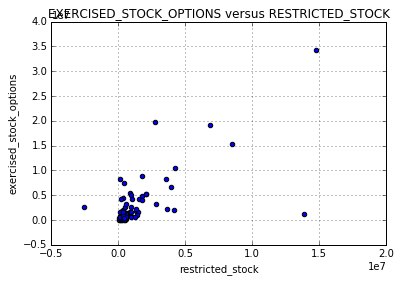

In [5]:
f1, f2 = 'restricted_stock','exercised_stock_options'
data = compareTwoFeatures(f1, f2, data_dict)

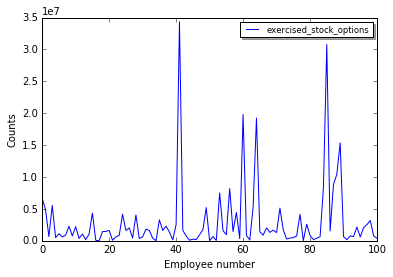

In [6]:
data = featureFormat(data_dict, [f2], remove_any_zeroes=True)

_= plt.plot(data, color="blue", label=f2)
_= plt.legend(loc='upper right', shadow=True, fontsize='small')
_= plt.xlabel('Employee number', fontsize=10)
_= plt.ylabel('Counts', fontsize=10)

plt.show()

In [7]:
treshold = 10000000
findPersonBasedOnTwoFeatures(f1, f2, data_dict, treshold)

FREVERT MARK A      restricted_stock is $4,188,667.00 exercised_stock_options is 10433518    
PAI LOU L           restricted_stock is $8,453,763.00 exercised_stock_options is 15364167    
SKILLING JEFFREY K  restricted_stock is $6,843,672.00 exercised_stock_options is 19250000    
RICE KENNETH D      restricted_stock is $2,748,364.00 exercised_stock_options is 19794175    
LAY KENNETH L       restricted_stock is $14,761,694.00 exercised_stock_options is 34348384    


### Engineered Feature
- #### Fraction of messages to and from POI

In [8]:
submit_dict = {}
for name in data_dict:

    data_point = data_dict[name]

    from_poi_to_this_person = data_point["from_poi_to_this_person"]
    to_messages = data_point["to_messages"]
    fraction_from_poi = computeFraction( from_poi_to_this_person, to_messages )
    #print'{:5}{:35}{:.2f}'.format('FROM ', name, fraction_from_poi)
    data_point["fraction_from_poi"] = fraction_from_poi


    from_this_person_to_poi = data_point["from_this_person_to_poi"]
    from_messages = data_point["from_messages"]
    fraction_to_poi = computeFraction( from_this_person_to_poi, from_messages )
    #print fraction_to_poi
    #print'{:5}{:35}{:.2f}'.format('TO: ', name, fraction_to_poi)
    submit_dict[name]={"from_poi_to_this_person":fraction_from_poi,
                       "from_this_person_to_poi":fraction_to_poi}
    
    data_point["fraction_to_poi"] = fraction_to_poi
    


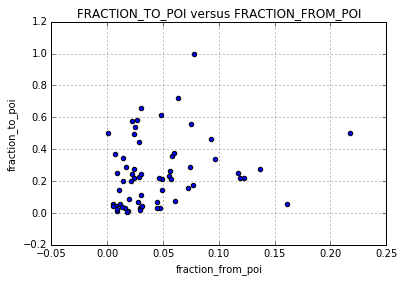

In [9]:
f1, f2 = 'fraction_from_poi','fraction_to_poi'
data = compareTwoFeatures(f1, f2, data_dict)

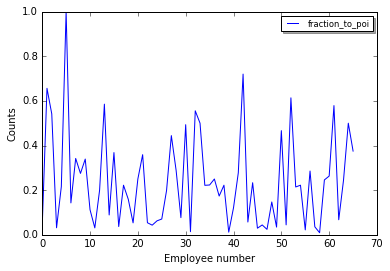

In [10]:
data = featureFormat(data_dict, [f2], remove_any_zeroes=True)

_= plt.plot(data, color="blue", label=f2)
_= plt.legend(loc='upper right', shadow=True, fontsize='small')
_= plt.xlabel('Employee number', fontsize=10)
_= plt.ylabel('Counts', fontsize=10)

plt.show()

## PCA

## Task 3: Create new feature(s)
- features_list is a list of strings, each of which is a feature name.
- The first feature must be "poi".
- Store to `my_dataset` for easy export below.

In [12]:
features_list = ['poi','salary', 'bonus', 'exercised_stock_options', 'restricted_stock',
                 'fraction_from_poi','fraction_to_poi',
                 'from_poi_to_this_person','from_this_person_to_poi'] 


In [13]:
my_dataset = data_dict

Extract features and labels from dataset for local testing

In [14]:
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

# Validate and Evaluate
## Task 5: Tune your classifier
- Achieve better than .3 precision and recall. Using our testing script. Check the `tester.py` script in the final project folder for details on the evaluation method, especially the test_classifier function. Because of the small size of the dataset, the script uses `stratified shuffle split cross validation`. For more info: http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html


In [15]:
# Example starting point. Try investigating other evaluation techniques!
from sklearn.cross_validation import train_test_split

features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

In [16]:
len(features_test)

40

# Pick and Tune an Algorithm
## Task 4: Try a variety of classifiers
- Please name your classifier clf for easy export below.
- Note that if you want to do PCA or other multi-stage operations, you'll need to use Pipelines. For more info: http://scikit-learn.org/stable/modules/pipeline.html

In [33]:
from sklearn.cross_validation import StratifiedShuffleSplit

PERF_FORMAT_STRING = "\
\tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\
\tFalse negatives: {:4d}\tTrue negatives: {:4d}"

def test_classifier(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        print "true_negatives: ",  true_negatives
    false_negatives = 0
    true_positives = 0
    false_positives = 0
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        print "accuracy: ", accuracy
        precision = 1.0*true_positives/(true_positives+false_positives)
        print "precision: ", precision
        recall = 1.0*true_positives/(true_positives+false_negatives)
        print "recall: ", recall
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        print "f1: ", f1
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print "f2: ", f2
        print clf
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
    except:
        print "Got a divide by zero when trying out:", clf
        print "Precision or recall may be undefined due to a lack of true positive predicitons."

In [34]:
from sklearn import svm
clf = svm.SVC(kernel="rbf")

clf.fit(features_train, labels_train)
pred = clf.predict(features_test)


In [35]:
test_classifier(clf, my_dataset, features_list, folds = 1000)

accuracy:  0.857142857143
Got a divide by zero when trying out: SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Precision or recall may be undefined due to a lack of true positive predicitons.


## Task 6: Export solution
Dump your classifier, dataset, and features_list so anyone can check your results. You do not need to change anything below, but make sure that the version of `poi_id.py` that you submit can be run on its own and generates the necessary .pkl files for validating your results.

In [ ]:
dump_classifier_and_data(clf, my_dataset, features_list)